<a href="https://colab.research.google.com/github/sajjad-shirazy/python-notebooks/blob/master/landing_page_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Landing page GAN (Generative Adversarial Networks)
Sajjad Shirazy @ Stijlbreuk - 2019



## Uploading data set from Google drive into the VM

In [4]:
# mounting google drive into this VM
from google.colab import drive
drive.mount('/content/gdrive')
print('mounted ...');

# unzipping the target
import zipfile

zip_ref = zipfile.ZipFile('/content/gdrive/My Drive/ML/1000-landing-pages.zip', 'r')
zip_ref.extractall('/data/1000-landing-pages')
zip_ref.close();
print('unzipped ...');
print('done');

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
mounted ...
unzipped ...
done


In [5]:
# check if every thing is ok
!ls /data/1000-landing-pages/ -U | head -4

5cac70f1194ca553458634.jpg
5b0c017f8e74b.jpg
586b69c3ea20f.jpg
5cd2a04a1d317040955559.png


## Importing packages

Let's start by importing required packages:

*   os — to read files and directory structure
*   numpy — for some matrix math outside of TensorFlow
*   matplotlib.pyplot — to plot the graph and display images in our training and validation data

For the TensorFlow imports, we directly specify Keras symbols (Sequential, Dense, etc.). This enables us to refer to these names directly in our code without having to qualify their full names (for example, `Dense` instead of `tf.keras.layer.Dense`).



In [6]:
!pip install tensorflow-gpu==2.0.0-alpha0

     |████████████████████████████████| 332.1MB 33kB/s 
     |████████████████████████████████| 419kB 38.3MB/s 
     |████████████████████████████████| 3.0MB 19.4MB/s 
     |████████████████████████████████| 61kB 23.1MB/s 


In [0]:
import os
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
# tf.logging.set_verbosity(tf.logging.ERROR)
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

## Setting Model Parameters

In [0]:
BATCH_SIZE = 64  # Number of training examples to process before updating our models variables
IMG_SHAPE_W  = 28  # Our training data consists of images with width of 320 pixels
IMG_SHAPE_H  = 28  # Our training data consists of images with height of 240 pixels
IMG_SHAPE_C  = 3  # CHANELS
latent_dim = 100;
img_shape = (IMG_SHAPE_W, IMG_SHAPE_H, IMG_SHAPE_C)

## Data Preparation
Images must be formatted into appropriately pre-processed floating point tensors before being fed into the network. The steps involved in preparing these images are:

1. Read images from the disk
2. Decode contents of these images and convert it into proper grid format as per their RGB content
3. Convert them into floating point tensors
4. Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.

Fortunately, all these tasks can be done using the class **tf.keras.preprocessing.image.ImageDataGenerator**.

In [49]:
train_image_generator = ImageDataGenerator(rescale=1./255)  # Generator for our training data
train_data_gen = train_image_generator.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory='/data/', 
    shuffle=True, 
    target_size=(IMG_SHAPE_W, IMG_SHAPE_H), #(150,150)
    class_mode='binary'
)

Found 986 images belonging to 1 classes.


### Visualizing Training images
We can visualize our training images by getting a batch of images from the training generator, and then plotting a few of them using matplotlib.

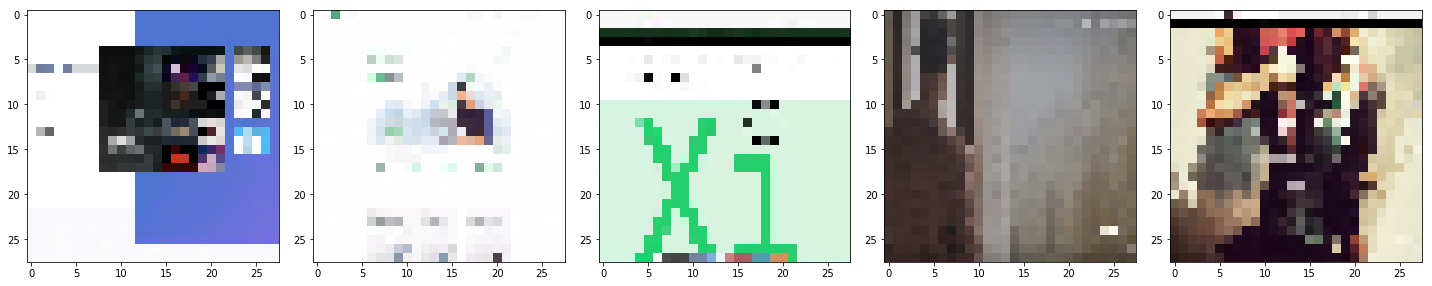

In [50]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

sample_training_images, _ = next(train_data_gen)     
plotImages(sample_training_images[:5])  # Plot images 0-4

The next function returns a batch from the dataset. One batch is a tuple of (many images, many labels). For right now, we're discarding the labels because we just want to look at the images.

## Create the models

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

In [0]:
def make_generator_model():
    model = tf.keras.Sequential()
#     model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
#     model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())

#     model.add(layers.Reshape((7, 7, 256)))
#     assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

#     model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
#     assert model.output_shape == (None, 7, 7, 128)
#     model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())

#     model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
#     assert model.output_shape == (None, 14, 14, 64)
#     model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())

#     model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
#     assert model.output_shape == (None, IMG_SHAPE_W, IMG_SHAPE_H, 1)

#     return model
    model.add(Dense(256, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))
    model.summary()
    noise = Input(shape=(latent_dim,))
    img = model(noise)
    return Model(noise, img)

Use the (as yet untrained) generator to create an image.

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_v2_3 (Ba (None, 256)               1024      
_________________________________________________________________
dense_8 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_v2_4 (Ba (None, 512)               2048      
_________________________________________________________________
dense_9 (Dense)              (None, 1024)             

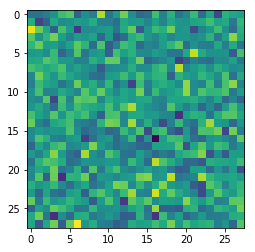

In [52]:
generator = make_generator_model()

noise = tf.random.normal([1, latent_dim])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

### The Discriminator

The discriminator is a CNN-based image classifier.

In [0]:
def make_discriminator_model():
#     model = tf.keras.Sequential()
#     model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
#                                      input_shape=[28, 28, 1]))
#     model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.3))

#     model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
#     model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.3))

#     model.add(layers.Flatten())
#     model.add(layers.Dense(1))
#     return model
    model = Sequential()

    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [54]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 2352)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               1204736   
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 257       
Total params: 1,336,321
Trainable params: 1,336,321
Non-trainable params: 0
____________________________________________

## Compiling models

In [0]:
optimizer = Adam(0.0002, 0.5)
# Build and compile the discriminator
discriminator.compile(loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])

# The generator takes noise as input and generates imgs
z = Input(shape=(latent_dim,))
img = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
validity = discriminator(img)

# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

In [0]:
def train(epochs, batch_size=128, sample_interval=50):

        # Load the dataset
#         (X_train, _), (_, _) = mnist.load_data()

      # Rescale -1 to 1
#         X_train = X_train / 127.5 - 1.
#         X_train = np.expand_dims(X_train, axis=3)

      # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):

          # ---------------------
          #  Train Discriminator
          # ---------------------

            # Select a random batch of images
  #             idx = np.random.randint(0, X_train.shape[0], batch_size)
  #             imgs = X_train[idx]
      if (((train_data_gen.batch_index + 1) * batch_size) > len(train_data_gen.filenames)) :
        train_data_gen.batch_index = 0;
      imgs, _ = next(train_data_gen) 
#       print(train_data_gen.batch_index);
#       print(len(train_data_gen.filenames));
#       imgs = imgs[0]

      noise = np.random.normal(0, 1, (batch_size, latent_dim))

      # Generate a batch of new images
      gen_imgs = generator.predict(noise)


      # Train the discriminator
      d_loss_real = discriminator.train_on_batch(imgs, valid)
      d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
      d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

      # ---------------------
      #  Train Generator
      # ---------------------

      noise = np.random.normal(0, 1, (batch_size, latent_dim))

      # Train the generator (to have the discriminator label samples as valid)
      g_loss = combined.train_on_batch(noise, valid)
      # Plot the progress
      print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

    # If at save interval => save generated image samples
#       if epoch % sample_interval == 0:
#           sample_images(epoch)

def sample_images(epoch):
    print('adasdasd');
    r, c = 5, 5
#     noise = np.random.normal(0, 1, (r * c, latent_dim))
    noise = tf.random.normal([1, latent_dim])
    gen_imgs = generator.predict(noise)
    plt.imshow(gen_imgs[0, :, :, 0])
    plt.close()

    # Rescale images 0 - 1
#     gen_imgs = 0.5 * gen_imgs + 0.5

#     fig, axs = plt.subplots(r, c)
#     cnt = 0
#     for i in range(r):
#         for j in range(c):
#             axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
#             axs[i,j].axis('off')
#             cnt += 1
#     plt.close()

In [58]:
train(epochs=500, batch_size=BATCH_SIZE, sample_interval=10)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


0 [D loss: 0.193060, acc.: 98.44%] [G loss: 1.394546]
1 [D loss: 0.188617, acc.: 98.44%] [G loss: 1.534960]
2 [D loss: 0.181363, acc.: 97.66%] [G loss: 1.643794]
3 [D loss: 0.179421, acc.: 97.66%] [G loss: 1.796298]
4 [D loss: 0.136645, acc.: 100.00%] [G loss: 2.063348]
5 [D loss: 0.139016, acc.: 97.66%] [G loss: 2.089296]
6 [D loss: 0.110410, acc.: 99.22%] [G loss: 2.205603]
7 [D loss: 0.124116, acc.: 96.88%] [G loss: 2.378851]
8 [D loss: 0.080380, acc.: 100.00%] [G loss: 2.475551]
9 [D loss: 0.105778, acc.: 96.88%] [G loss: 2.596836]
10 [D loss: 0.079090, acc.: 99.22%] [G loss: 2.630761]
11 [D loss: 0.104242, acc.: 97.66%] [G loss: 2.666892]
12 [D loss: 0.100795, acc.: 98.44%] [G loss: 2.725355]
13 [D loss: 0.075659, acc.: 100.00%] [G loss: 2.681191]
14 [D loss: 0.070504, acc.: 98.44%] [G loss: 2.785268]
15 [D loss: 0.072887, acc.: 100.00%] [G loss: 2.860280]
16 [D loss: 0.087376, acc.: 98.44%] [G loss: 2.908003]
17 [D loss: 0.061840, acc.: 100.00%] [G loss: 2.996958]
18 [D loss: 0.0

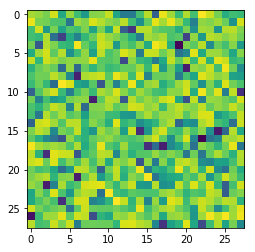

In [64]:
noise = tf.random.normal([1, latent_dim])
gen_imgs = generator.predict(noise)
plt.imshow(gen_imgs[0, :, :, 0])